<h1><center><strong> Prophet - Time Series Forecasting </strong></center> </h1>

---
</br>

This project will work with time series (*time series*) and the ***Prophet*** tool. Specifically, we will make the prediction related to the outcomes of animals in a shelter.

Before getting into the project, let's get to know Prophet and why it is so useful at handling temporal data. 

</br></br>

### Prophet and Time-Series

---

Making good predictions with temporal data is a highly complex task. Given the complexity of statistical models, *time series* represent a challenge for *machine learning* engineers, statisticians, and economists.

That said, trying to implement a model without using any *framework* implies a deep understanding of a theory that is not trivial and that requires a certain degree of specialization.

***Prophet*** is a *framework* designed work on time-series forecasting and it is available as an open-source project made by **Facebook** team. You can use it in ***R*** or ***Python***, in our case it will be tested in python.

<p align="center"><img src="https://facebook.github.io/prophet/static/quick_start_files/quick_start_12_0.png" height="300px"></p>

Prophet Documentation:  https://facebook.github.io/prophet/

In [1]:
# Installing the animal shelter package ( This cell is in case you want to run this notebook on google colab)
!pip install sodapy

In [2]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

# Basic Libs for data handling ans analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Prophet libs and modules
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Plotting libs
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
# Plot Config
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Setting Seaborn Theme
sns.set_theme(style="whitegrid", font_scale=1.4)

In [4]:
# import shelter official API
from sodapy import Socrata

# Connecting to the API
client = Socrata("data.austintexas.gov", None)
results = client.get("9t4d-g238", limit=131000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

print("\nSHELTER DATASET")
print("_________________")
print(f"Dataset Shape:\nRows:{df.shape[0]}\nColumns:{df.shape[1]}")

print(df.head())


SHELTER DATASET
_________________
Dataset Shape:
Rows:131000
Columns:12
  animal_id    name  ...        color outcome_subtype
0   A842860    Milo  ...        White             NaN
1   A842419     NaN  ...  Brown/Black         Partner
2   A842851     NaN  ...     Gray/Red     Rabies Risk
3   A842564    Nova  ...  Black/White             NaN
4   A842272  Punkin  ...  Black/White             NaN

[5 rows x 12 columns]


# Exploratory Analysis

In [5]:
# Getting data types and non-null values
print(df.info(), '\n\n')


# get summary of the main dataset statistics
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131000 entries, 0 to 130999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   animal_id         131000 non-null  object        
 1   name              90869 non-null   object        
 2   datetime          131000 non-null  datetime64[ns]
 3   monthyear         131000 non-null  object        
 4   date_of_birth     131000 non-null  object        
 5   outcome_type      130976 non-null  object        
 6   animal_type       131000 non-null  object        
 7   sex_upon_outcome  131000 non-null  object        
 8   age_upon_outcome  131000 non-null  object        
 9   breed             131000 non-null  object        
 10  color             131000 non-null  object        
 11  outcome_subtype   60169 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 12.0+ MB
None 




,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
count,131000,90869,131000,131000,131000,130976,131000,131000,131000,131000,131000,60169
unique,117145,21518,108628,108628,7359,9,5,6,53,2679,606,24
top,A721033,Max,2016-04-18 00:00:00,2016-04-18T00:00:00.000,2014-04-21T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Partner
freq,33,591,39,39,117,59201,73738,46087,22965,31692,13696,32217
first,NaN,NaN,2013-10-11 11:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-09-22 14:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Getting NaN values
df.isnull().sum().sort_values(ascending=False)

outcome_subtype     70831
name                40131
outcome_type           24
color                   0
breed                   0
age_upon_outcome        0
sex_upon_outcome        0
animal_type             0
date_of_birth           0
monthyear               0
datetime                0
animal_id               0
dtype: int64

In [7]:
# Checking all outcomes possible
print(f"OUTCOME TYPES: \n{df['outcome_type'].value_counts()}  \n\n")

# Checking all animal types
print(f"ANIMAL TYPES: \n{df['animal_type'].value_counts()}")

OUTCOME TYPES: 
Adoption           59201
Transfer           38237
Return to Owner    22089
Euthanasia          8738
Died                1236
Rto-Adopt            783
Disposal             598
Missing               70
Relocate              24
Name: outcome_type, dtype: int64  


ANIMAL TYPES: 
Dog          73738
Cat          49645
Other         6976
Bird           617
Livestock       24
Name: animal_type, dtype: int64


In [8]:
# Check only 'Adoption' and 'Return to Owner' outcomes
adoptions_df = df[(df['outcome_type'] == 'Adoption') | (df['outcome_type'] == 'Return to Owner')]
adoptions_df['outcomeCount'] = 1
adoptions_df = adoptions_df.set_index('datetime').sort_index()

# Checking all animal types
print(f"Adopted or returned to owner by Animal Type: \n{adoptions_df['animal_type'].value_counts()}\n\n")

# first and last dataset dates
print(f"First Date: {adoptions_df.index.min().strftime('%d %b %Y')}")
print(f"Last Date: {adoptions_df.index.max().strftime('%d %b %Y')}\n")

Adopted or returned to owner by Animal Type: 
Dog          54942
Cat          25428
Other          657
Bird           246
Livestock       17
Name: animal_type, dtype: int64


First Date: 11 Oct 2013
Last Date: 22 Sep 2021



Other animals, birds, and livestock seems to be irrelevant to the total adoptions count considering data lenght too. As we probably will notice differences in the 2020-2021 adoptions numbers, it is good to check euthanasia outcomes for comparison.



In [9]:
euthanasia_df = df[(df['outcome_type'] == 'Euthanasia')]
euthanasia_df['outcomeCount'] = 1
euthanasia_df = euthanasia_df.set_index('datetime').sort_index()

# Checking all animal types
print(f"Euthanasia by Animal Type: \n{euthanasia_df['animal_type'].value_counts()}\n\n")

Euthanasia by Animal Type: 
Other        4740
Cat          2049
Dog          1825
Bird          123
Livestock       1
Name: animal_type, dtype: int64




Here we can see that 'Other' Animals types are usually sacrificed. With visualization purposes and compare euthanasia and adoptions count, i will select only cats and dogs.

In [10]:
# Filtering by animal type
adoptions_df = adoptions_df.loc[(adoptions_df['animal_type'] == 'Cat') | (adoptions_df['animal_type'] == 'Dog')]
euthanasia_df = euthanasia_df.loc[(euthanasia_df['animal_type'] == 'Cat') | (euthanasia_df['animal_type'] == 'Dog')]

Now we will check daily and weekly data from euthanasia and adoptions subsets.

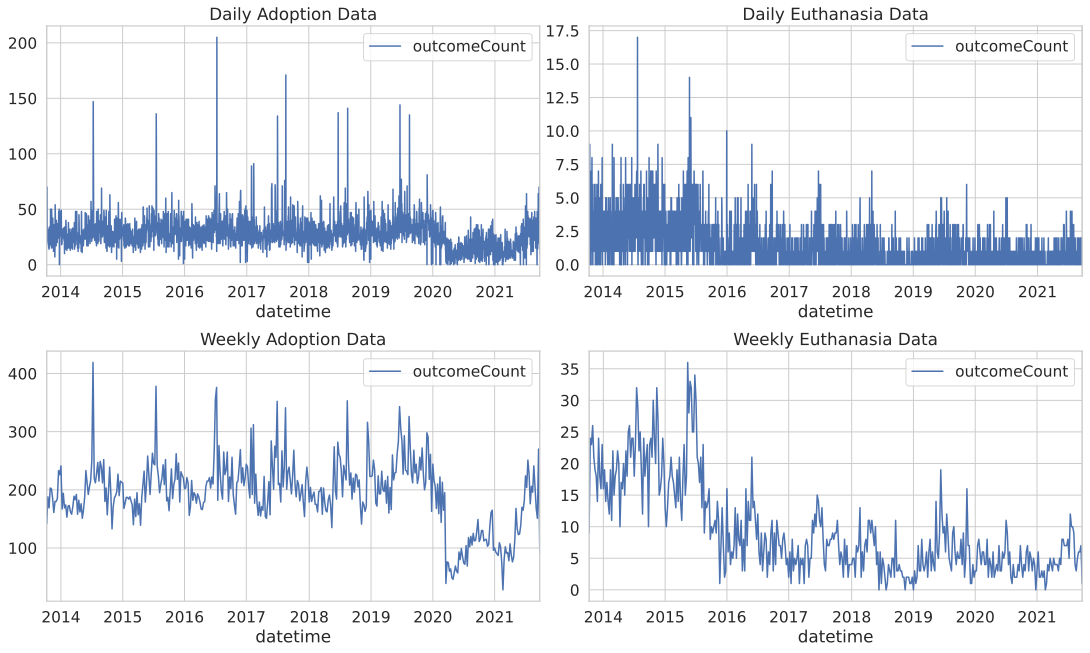

In [11]:
plt.rcParams["figure.figsize"] = (18,10)
fig1, axs = plt.subplots(nrows=2, ncols=2)

axs[0,0] = adoptions_df.resample('D').sum().plot(ax = axs[0,0], title='Daily Adoption Data')
axs[1,0] = adoptions_df.resample('W').sum().plot(ax = axs[1,0], title='Weekly Adoption Data')
axs[0,1] = euthanasia_df.resample('D').sum().plot(ax = axs[0,1], title='Daily Euthanasia Data')
axs[1,1] = euthanasia_df.resample('W').sum().plot(ax = axs[1,1], title='Weekly Euthanasia Data')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

While adoption numbers seem to be lower in 'covid' years, euthanasia numbers didn't change much. So apparently there isn't a big relationship between adoptions and euthanasia.

---



Looking at adoptions data plot i could take the risk and say it is stationary, but it is better to really check.

### Stationary Check

In order to check if it is stationary or non-stationary, we will use the p-value of the Augmented Dickey-Fuller test on daily frequency data.

- p-value > 0.05: is non-stationary.
- p-value <= 0.05: is stationary.

In [12]:
def apply_dickey_fuller(data):
    "Get time series and prints output of 'adfuller'"

    result = adfuller(data)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

# Full data on adoptions count (including 2020-2021)
daily_adoptions_full = adoptions_df['outcomeCount'].resample('D').sum()

# Data limited until 2019
daily_adoptions_limited = adoptions_df.loc[:'2019']['outcomeCount'].resample('D').sum()

print("Full Data:\n")
apply_dickey_fuller(daily_adoptions_full)

print("\n\nData without 2020-2021:\n")
apply_dickey_fuller(daily_adoptions_limited)

Full Data:

ADF Statistic: -3.499580
p-value: 0.007998
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Data without 2020-2021:

ADF Statistic: -5.473832
p-value: 0.000002
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


As the test statistic ('ADF Statistic') value is less than -5. The more negative this statistic, the more likely is that we have a stationary dataset.

Since one of the purposes of this work is to learn how to use Prophet, we need to do some steps first.

Prophet uses a decomposed time series model with three main components: trend, seasonality and holidays:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

Where:

- g(t) is the trend, which models the non-periodic changes in the value of the time series;
- s(t) represents periodic changes (such as weekly, annual seasonality, etc.);
- h(t) represents the effects of holidays; and
- $\varepsilon_t$ is the error, the changes that are not captured by the model (this is assumed to have a normal distribution). 

So, first, we need to check autocorrelation since it is a mathematical tool for finding repeating patterns. Because Prophet uses only one feature and its lagged values, we need to check autocorrelation. Prophet does this in a far better way, but the idea here is to check with other ways and only then see how useful ***Prophet*** can be.

Note: I will use weekly frequency in this part for visual purposes and to avoid noise.

### Autocorrelation 

Here we will check autocorrelation as one of the steps of a time-series analysis.

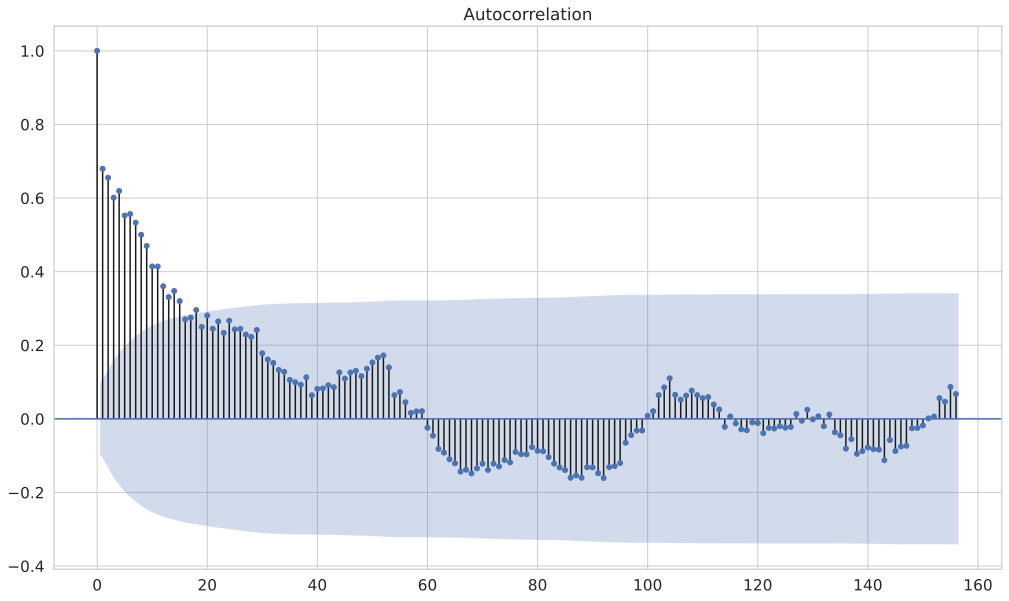

In [13]:
# Plot Autocorrelation
plt.rcParams["figure.figsize"] = (17,10)
plot_acf(adoptions_df[['outcomeCount']].resample('W').sum(), lags=156)
plt.show()

Above is an example of an autocorrelation plot, but this plot doesn't show us patterns that indicate any seasonality, at least not enough to confirm or deny it.

My best guess is that the Pandemic period was an unexpected event that probably changed patterns in the short term. It is better to get autocorrelation without 2020-2021 data since the way it is doesn't give us any hint. 

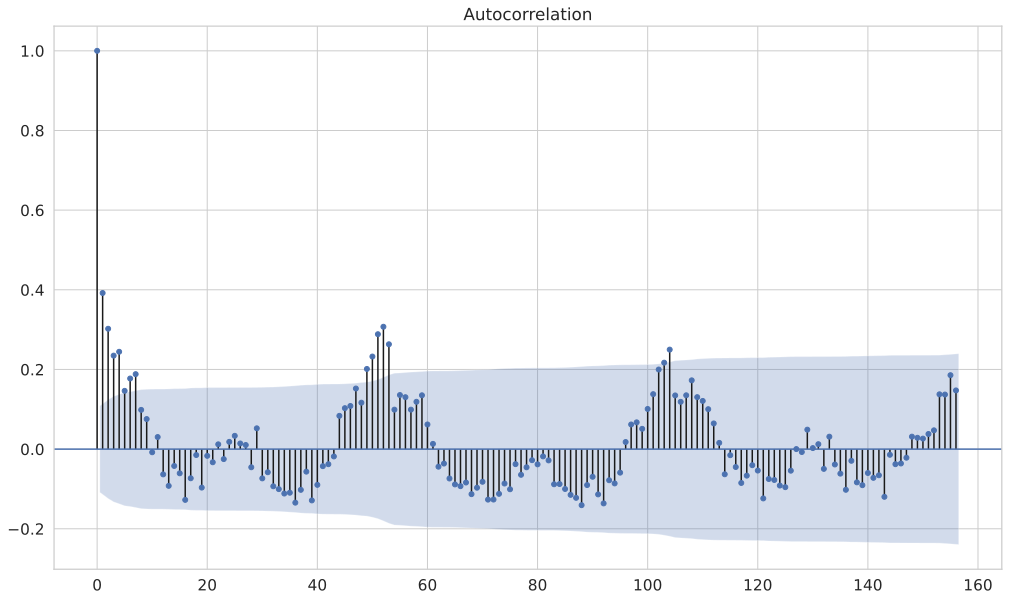

In [14]:
# Plot Autocorrelation
plt.rcParams["figure.figsize"] = (17,10)
plot_acf(adoptions_df.loc[:'2019'][['outcomeCount']].resample('W').sum(), lags=156)
plt.show()

Now, without the years 2020-2021, we can finally see some traces of seasonality. Looking closely, we can see that the first value and approximately the 50th have a high correlation, as well as approximately the 50th and  the100th. This makes us think that we have a seasonality since a year has approximately 52 weeks.

 It is confirmed that Covid data changed the autocorrelation analysis, we have to keep in mind this fact that an external event had impact on this time-series. This means that for this exercise I will need to limit data to see ***Prophet***'s implementation working with an acceptable performance.

To do so, the last date in the model input will be Dec 2018, so we can forecast 365 forward without forecasting pandemic dates.

---

### Seasonality

Seasonality refers to periodic fluctuations. (e.g. beach areas have more tourists during the summer)

Now we will decompose this time-series and look for seasonality 

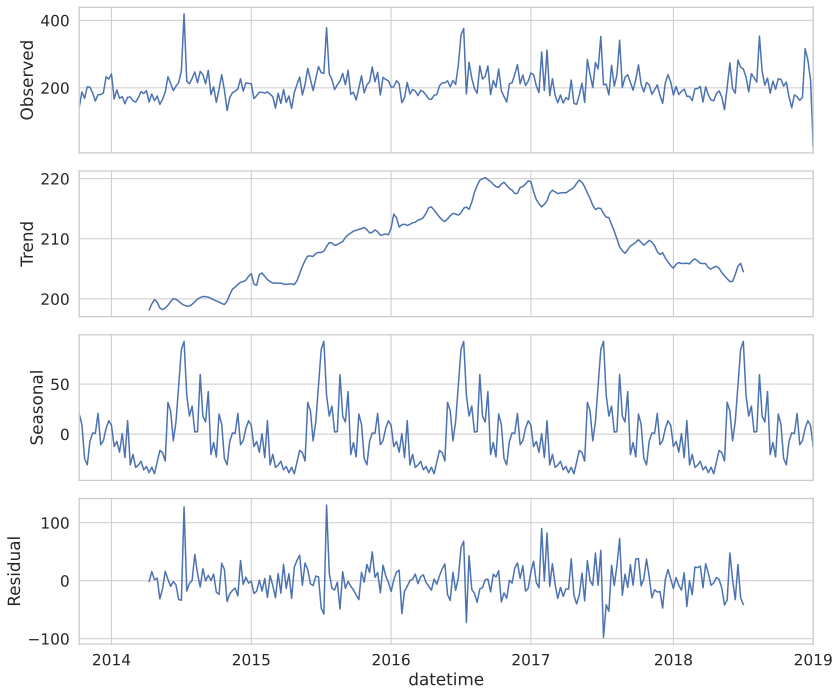

In [15]:
plt.rcParams["figure.figsize"] = (12,10)
res = seasonal_decompose(adoptions_df.loc[:'2018']['outcomeCount'].resample('W').sum())
res.plot();

This seasonal decomposed chart give us some information and we can see that there are higher number of adoptions in the middle of the year, but at this point doesn't have the amount of details that we expect. 

Later we will see that prophet makes this kind of task easier AND better too.

# Preparing Data for Prophet input format

Prophet Documentation states that the input to Prophet is always a dataframe with two columns: ds and y
</br></br>
<strong>'ds' - datestamp column should be in the following formats:</strong>

- 'YYYY-MM-DD' format for dates
- 'YYYY-MM-DD HH:MM:SS' for a timestamp

</br>
<strong>'y' - this column must be numeric</strong>

In [16]:
# Initially work with daily data
prophet_df = adoptions_df.loc[:'2018'].resample('D').sum().reset_index().rename(columns={'datetime':'ds', 'outcomeCount':'y'})

# Check if we filtered correct
prophet_df.tail()

,ds,y
1903,2018-12-27,48
1904,2018-12-28,30
1905,2018-12-29,37
1906,2018-12-30,36
1907,2018-12-31,27


Seems ready to go.

# Creating Forecast model

To fully understand the differences in usage and time frames, data will be tested on a daily and weekly basis.

## Daily Data

In [17]:
# Init and train Prophet
model = Prophet(daily_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(prophet_df)

# Define and create range of days to be forecast.
future = model.make_future_dataframe(periods=730)

# Predict 'future days'
forecast = model.predict(future)

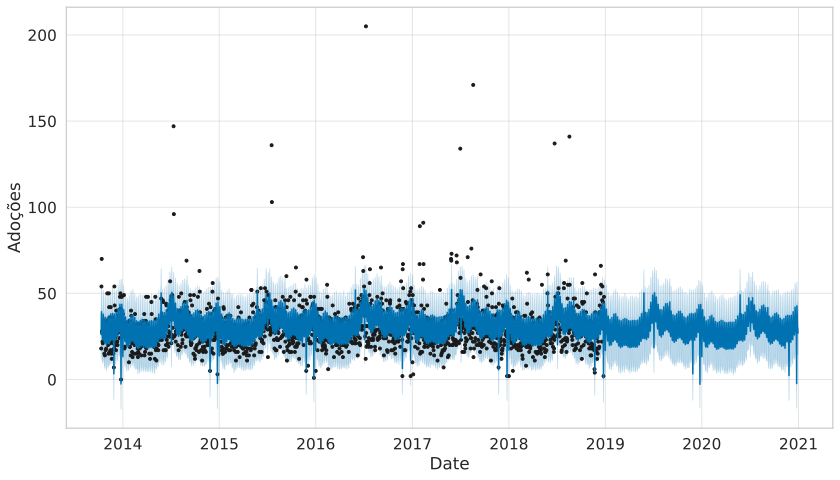

In [18]:
# Plot chart with forecasts
model.plot(forecast, xlabel='Date', ylabel='Adoções', figsize=(12,7));

As we can see, predictions for 2020 couldn't predict 'covid-effect', which it was already expected since Prophet time-series forecasting leverages from auto-correlation and don't use other features.

Now as said earlier, we will see Prophet time-series decomposition. Which is much more informative without much effort.

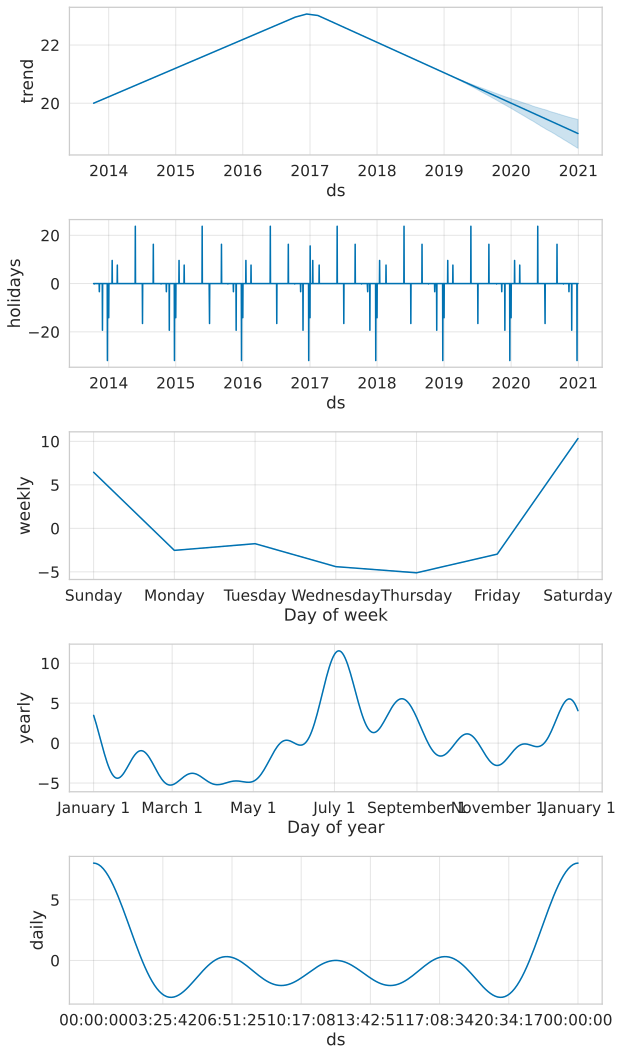

In [19]:
# separar os componentes do modelo
model.plot_components(forecast);

With the decomposition done by ***Prophet***, we were able to have a better visualization of the time-series patterns.

We can see that:
- The adoptions peak is in July and that
- Adoptions usually happens on weekends

## Weekly Data

In [20]:
# criar um modelo baseado em semanas
prophet_df2 = adoptions_df.loc[:'2018'].resample('W').sum().reset_index().rename(columns={'datetime':'ds', 'outcomeCount':'y'})

# instanciar e treinar o modelo
model2 = Prophet(weekly_seasonality=True)
#model2.add_country_holidays(country_name='US')
model2.fit(prophet_df2)

# determinar o período de dias para previsão
future2 = model2.make_future_dataframe(periods=104, freq='W')

# realizar a previsão para o período estabelecido
forecast2 = model2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


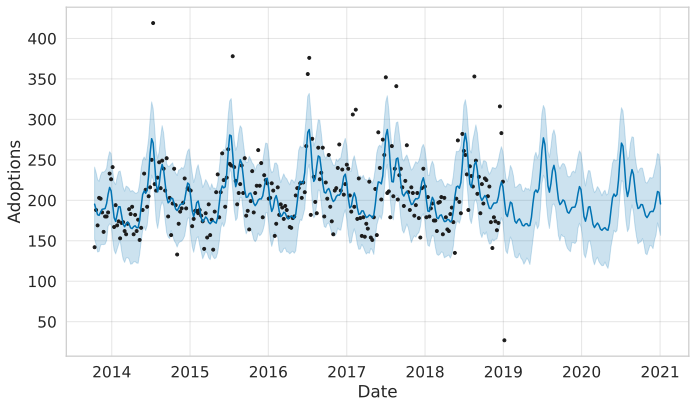

In [21]:
# visualizar o gráfico com as previsões
model2.plot(forecast2, xlabel='Date', ylabel='Adoptions');

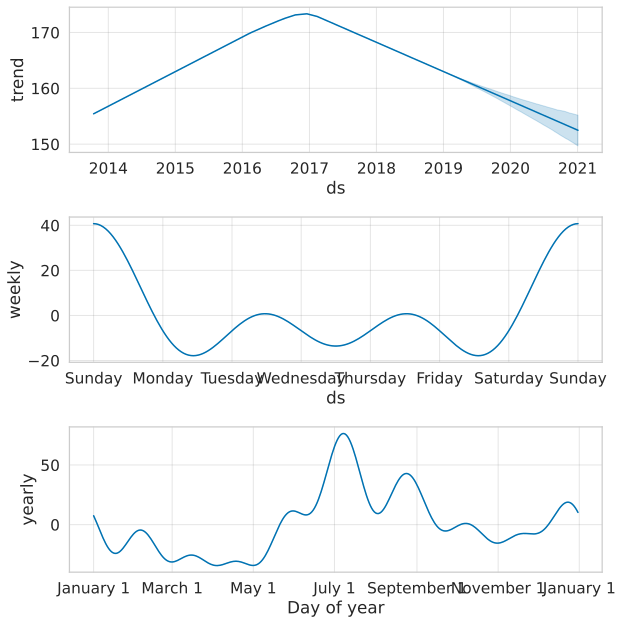

In [22]:
# separar os componentes do modelo
model2.plot_components(forecast2);

### Time-series evaluation

#### Modelo Preditivo do Prophet

Como dissemos acima, o Prophet foi feito para solucionar problemas do Facebook. Ou seja, é muito forte para lidar com problemas que tenham características como:

* Dados coletados por um longo período (meses ou anos), e que possuam o maior detalhamento histórico possível.
* Sazonalidades fortes e destacadas.
* Feriados ou datas especiais conhecidas *a priori*.
* Tendência de crescimento não linear, que se aproxima de um limite.

#### Model: Daily

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-01-11 00:00:00 and 2017-12-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

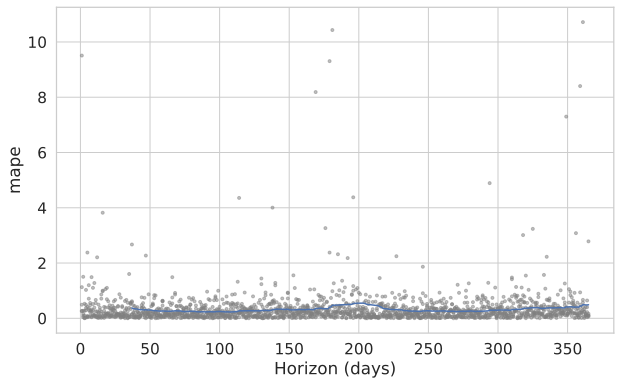

     horizon         mse       rmse        mae      mape     mdape  coverage
0    37 days  162.080997  12.731104   8.837159  0.374319  0.181696  0.762637
1    38 days  161.123832  12.693456   8.749617  0.346999  0.181696  0.767033
2    39 days  164.255224  12.816209   8.791834  0.344523  0.180733  0.767033
3    40 days  161.020608  12.689390   8.636381  0.338617  0.172575  0.773626
4    41 days  154.542898  12.431528   8.468049  0.329365  0.168307  0.783516
..       ...         ...        ...        ...       ...       ...       ...
324 361 days  207.907297  14.418991  10.288349  0.493512  0.264656  0.739560
325 362 days  207.726482  14.412719  10.283883  0.486283  0.268223  0.741758
326 363 days  203.804472  14.276010  10.172333  0.483084  0.262399  0.742857
327 364 days  203.865543  14.278149  10.166994  0.481918  0.262399  0.741758
328 365 days  211.387117  14.539158  10.196425  0.488432  0.249673  0.742857

[329 rows x 7 columns]


In [23]:
# Making cross validation with Prophet
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

plot_cross_validation_metric(df_cv, metric='mape');
plt.show()
print(df_p)

Forecasting based on daily data doesn't look impressive at all, daily data usually have more noise and this can make predictions a hard task in some situations.

#### Model: Weekly

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-01-17 00:00:00 and 2018-01-06 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

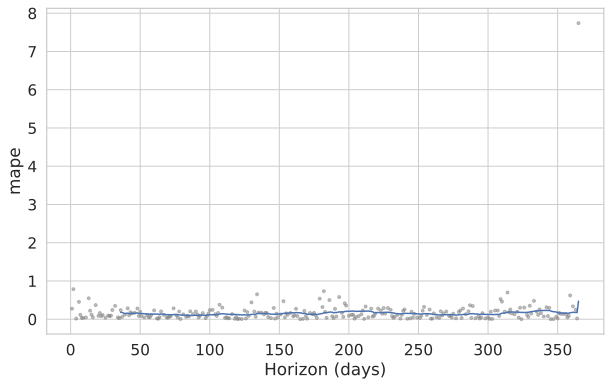

     horizon          mse       rmse        mae      mape     mdape  coverage
0    36 days  2924.284478  54.076654  37.850218  0.182058  0.103523  0.653846
1    37 days  2841.285507  53.303710  36.584406  0.173847  0.095400  0.692308
2    39 days  2069.773383  45.494762  31.876546  0.148104  0.095400  0.730769
3    41 days  2433.267713  49.328163  35.481854  0.158415  0.103523  0.692308
4    42 days  2096.016941  45.782278  32.567055  0.144899  0.099322  0.730769
..       ...          ...        ...        ...       ...       ...       ...
231 359 days  2196.212530  46.863766  36.362788  0.168591  0.133320  0.576923
232 361 days  2336.075881  48.332969  38.678366  0.181533  0.137612  0.538462
233 363 days  2379.428246  48.779383  39.045684  0.179397  0.137612  0.538462
234 364 days  2342.171356  48.395985  37.996543  0.175759  0.137612  0.538462
235 365 days  4014.314220  63.358616  45.493814  0.471182  0.144999  0.500000

[236 rows x 7 columns]


In [24]:
# Making cross validation with Prophet
df_cv2 = cross_validation(model2,  initial='730 days', period='180 days', horizon = '365 days')

df_p2 = performance_metrics(df_cv2)
plot_cross_validation_metric(df_cv2, metric='mape');
plt.show()
print(df_p2)

## **Comments**

- It was possible to notice that Prophet is very easy to implement and also can be used to check time series data, which can get rich insights and hints based on variation of values by day of the week and also possible to clearly identify the seasonality of the months.

- It was also possible to notice that larger temporal windows, for example the test with weekly frequency performed considerably better than using the daily frequency. This can be explained by a higher amount of noise contained in series with higher frequency.

- For ease of implementation and also to check out some aspects of a time series I would easily opt to use Prophet, at least at the start of a project.

# ***Extra:*** Covid Years and Challenges

As we previously saw, this time series had meaningful changes due to covid pandemic period. But we should test our daily and weekly trained models so we can check how our model performs in this situation.

In [25]:
# Selecting data from the original dataset with only 2020 and 2021 data

# Setting Daily Input
covid_dates_data_daily = adoptions_df.loc['2020':,].resample('D').sum().reset_index().rename(columns={'datetime':'ds'}).copy()
covid_dates_data_daily = covid_dates_data_daily[['ds']]

# Setting Weekly Input
covid_dates_data_weekly = adoptions_df.loc['2020':,].resample('W').sum().reset_index().rename(columns={'datetime':'ds'}).copy()
covid_dates_data_weekly = covid_dates_data_weekly[['ds']]

# Getting outcomes date to compare
covid_dates_outcome = adoptions_df.loc['2020':][['outcomeCount']].rename(columns={'outcomeCount':'Real Outcome'}).copy()
covid_dates_outcome = covid_dates_outcome.resample('D').sum()

Data is ready to be predicted in Prophet input format.

In [26]:
# Predicting outcomes
covid_dates_predictions_d = model.predict(covid_dates_data_daily) # Daily Predictions
covid_dates_predictions_d.set_index('ds',drop=True,inplace=True)
covid_dates_predictions_d = covid_dates_predictions_d[['yhat']].rename(columns={'yhat': 'Outcome Predictions'})

covid_dates_predictions_w = model2.predict(covid_dates_data_weekly) # Weekly Predictions
covid_dates_predictions_w.set_index('ds',drop=True,inplace=True)
covid_dates_predictions_w = covid_dates_predictions_w[['yhat']].rename(columns={'yhat': 'Outcome Predictions'})

Forecasting: Daily Freq

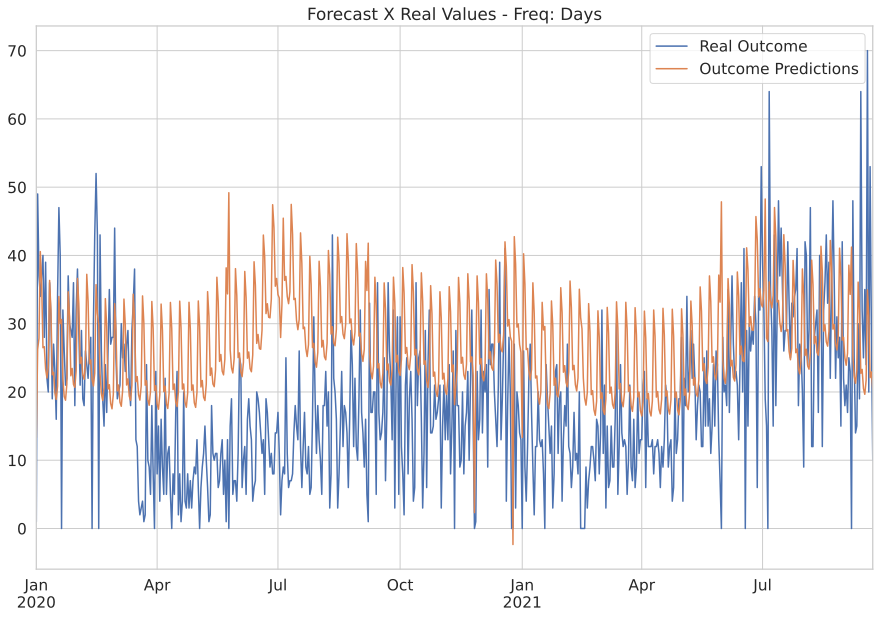

In [27]:
# Plotting Predicted vs Real Data
daily_outcome = pd.concat([ covid_dates_outcome, covid_dates_predictions_d], axis=1)
daily_outcome.plot(figsize=(15,10), title='Forecast X Real Values - Freq: Days')

Forecasting: Weekly Freq

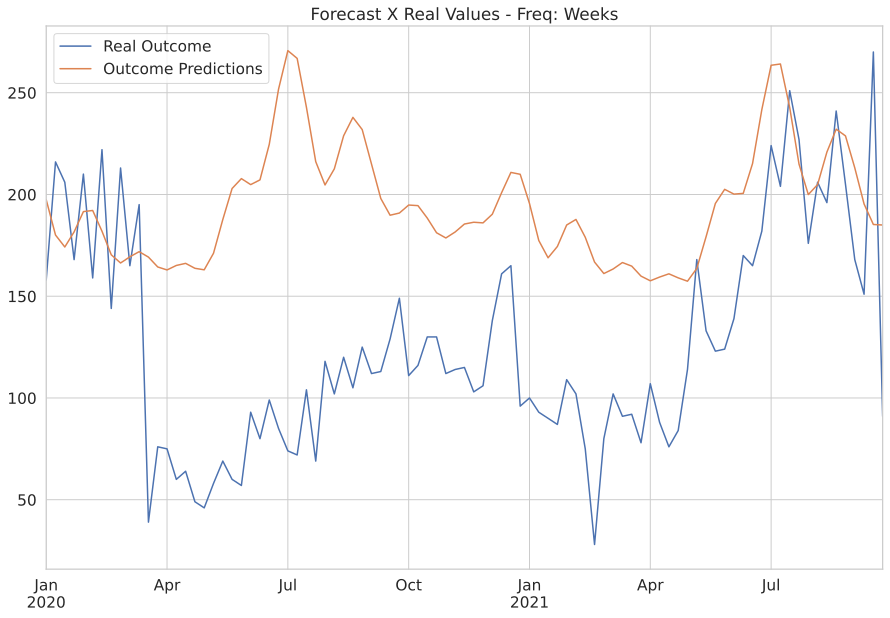

In [28]:
# Plotting Predicted vs Real Data
weekly_outcome = pd.concat([ covid_dates_outcome.resample('W').sum(), covid_dates_predictions_w], axis=1)
weekly_outcome.plot(figsize=(15,10), title='Forecast X Real Values - Freq: Weeks')

<h2><center><strong> Conclusions on Forecasting 2020-2021

---

We can see clearly (more easily on week basis forecast) that our model using Prophet cannot make predictions in scenarios where some external/unexpected event happens, since it forecast based on autocorrelation,  seasonality, and trend. Other regression techniques that use more features probably could have better results in a scenario like this with the correct data.

Well, we all assume that covid was the responsible for the lower adoptions number. Looking at data "it is clear" that this is the case, but can we prove it ?

<h1><strong><center>“In God we trust. All others must bring data.”</center></strong></h1>

Luckly, we can get other data that can be used to look if that's the case, Federal Reserve Bank of Dallas has an index created specially for this period: **Mobility and Engagement Index (MEI)**. [( Link here )](https://www.dallasfed.org/research/mei)


**About MEI:**
"The Dallas Fed Mobility and Engagement Index (MEI) summarizes the information in seven different variables based on geolocation data collected from a large sample of mobile devices to gain insight into the economic impact of the pandemic. The MEI measures the deviation from normal mobility behaviors induced by COVID-19. MEI data is updated every Wednesday by noon CT."

---



**NOTE:** MEI index starts at January 2020 and it ends March 2021, which is enough for us to have some idea of the relationship between COVID and animal adoption for this period.

In [29]:
mei_df = pd.read_excel('austin.xlsx')

mei_df['DateTime'] = pd.to_datetime(mei_df['DateTime'], format="%Y-%m-%d %H:%M")
mei_df.set_index('DateTime',inplace=True)
mei_df.rename(columns={'Austin-Round Rock-Georgetown, TX':'Austin'}, inplace=True)

,Austin - Mobility and Engagement Index,outcomeCount
Austin - Mobility and Engagement Index,1.000000,0.816875
outcomeCount,0.816875,1.000000


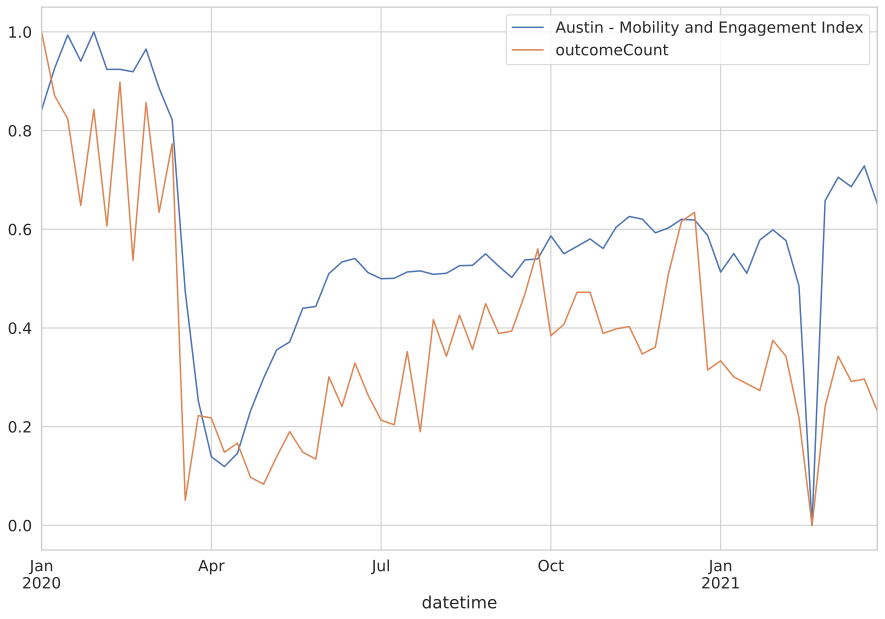

In [30]:
# Putting outcome data and MEI Index for Austin data in a single dataframe
analysis_df = pd.concat([mei_df.resample('W').sum()['Austin'], adoptions_df['outcomeCount'].resample('W').sum()],axis=1)
analysis_df.dropna(inplace=True)
analysis_index = analysis_df.index

# Scaling data to make it easier to compare.
analysis_df = pd.DataFrame(MinMaxScaler().fit_transform(analysis_df))
analysis_df.columns = ['Austin - Mobility and Engagement Index', 'outcomeCount']
analysis_df.index = analysis_index
analysis_df.plot.line(figsize=(15,10));
display(analysis_df.corr())

The similarity between the index and the number of adoptions, even in the case of a quick look at the plotted graph, we can see how the movement is similar and how mobility restrictions, whether forced by the state or by people's personal choice, affected in some proportion the number of adoptions.